# Assignment 1 (shortened)

This notebook contains three exercises from the exercise sets we covered prior to moving the teaching online. It will count as one of the two assignments you need to submit to qualify for the exam. **The deadline** for handing in this assignment is **April 3.** You hand in by pushing your solutions to your folder in the exercise repo.

## Problems from exercise set 2
> **Ex. 2.1.1**: The performance of a random forest classifier is highly sensitive to hyper parameters. Therefore, you should be intimately familiar with what the most important ones do. For each point below, explain what the hyper parameter pertaining to `sklearn.ensemble.RandomForestClassifier` controls, and how setting it either too low or too high (or True/False) might hurt model performance:
1. `n_estimators`
2. `max_depth`
3. `max_features`
4. `bootstrap`

**Answer:**
1. `n_estimators`: **The number of trees in the forest**
 - If we set it too high, the model is going to take very long to fit. Furthermore, it increases the risk of overfitting.
 - If we set it too low, the model becomes poor at predicting the classes correctly. 


2. `max_depth`: **The maximum depth of each tree in the forest**
 - The same as for `n_estimators`
 
 
3. `max_features`: **The number of features in each tree in the forest**
 - The same as for `n_estimators`


4. `bootstrap`: **If the data should be bootstrapped for each tree**
 - If we set this to true, it will require more computation, as a random bootstrap sample will have to be drawn for each tree.
 - If we set this to low, we will get less varied trees. The risk is that the predictive power of the model will suffer.

> **Ex. 2.1.2**: For `n_estimators > 1`how should one set the hyper-parameters `max_features` and `bootstrap` so that all the trees in the ensemble end up identical?

**Answer:** If we set `max_features = total_features` and `bootstrap = False` we will have eliminated both sources of randomness in the random forest --- the random selection of a subset of features and the bootstrapping of the data. Thus, each tree will be the same, using all the features and the original dataset.

## Problems from exercise set 3

> **Ex. 3.1.2**: Reproduce the figure from the slides that compares PCA, LDA, t-SNE and UMAP as applied to the digits dataset.
1. Do it for the digits dataset (same as in slides)
2. Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?
3. Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.
>
> *Hint: You can use [this class](https://github.com/ulfaslak/ulf_pytools/blob/7f4f1eb7e2d721851c8dacb20904478b19090f2a/ulf.py#L451) for making coloring easier. It lets you create a function that takes a category as input and returns an associated color. Read the docstring for usage example.*

In [1]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits

# Get wine data
data_wine = load_wine()
X_wine = data_wine['data']
y_wine = data_wine['target']

# Get digits data
data_digits = load_digits()
X_digits = data_digits['data']
y_digits = data_digits['target']

In [2]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler

# Function for plotting two first principal components of reducer
# on dataset X,y in ax
def plot_reducer(reducer, X, y, ax, standardize = True):
    # Standardize data
    if standardize:
        ssc = StandardScaler()
        X_std = ssc.fit_transform(X)
    else:
        X_std = X
    
    # Compute principal components
    if reducer == LDA:
        pcs = reducer().fit_transform(X_std, y)
    else:
        pcs = reducer().fit_transform(X_std)
    
    # Plot two first principal components
    sct = ax.scatter(pcs[:,0], pcs[:,1], c=y, cmap='viridis')
    ax.set_title(reducer.__name__)

C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


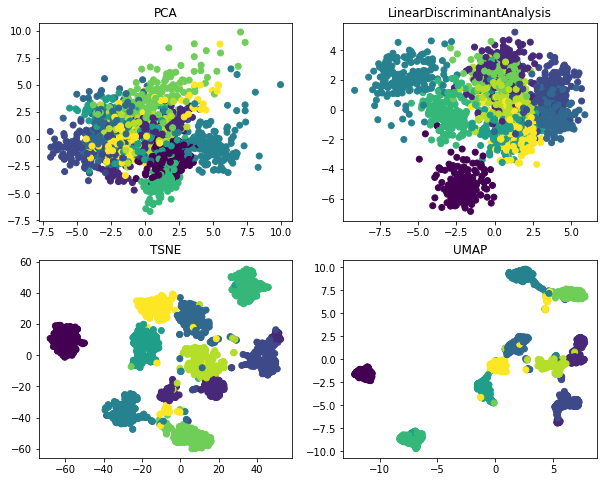

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

# 1. Plot for digits data
# Make scatter plot of first two principal components
fig, ax = plt.subplots(2,2, figsize=(10,8))
plot_reducer(PCA, X_digits, y_digits, ax[0][0])
plot_reducer(LDA, X_digits, y_digits, ax[0][1])
plot_reducer(TSNE, X_digits, y_digits, ax[1][0])
plot_reducer(UMAP, X_digits, y_digits, ax[1][1])

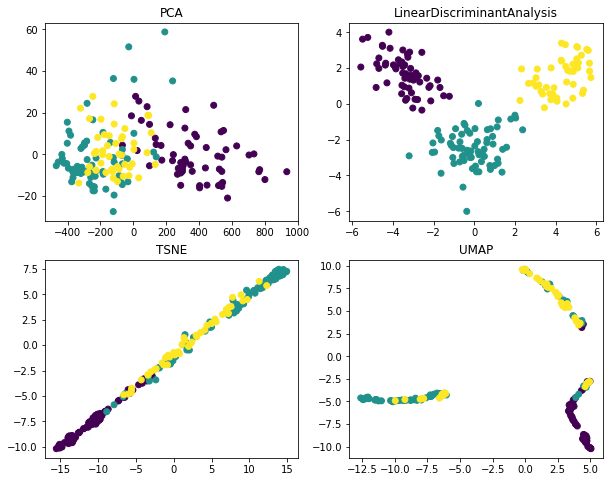

In [5]:
# 2. Plots for Wine data
# Plot WITHOUT standardizing
fig, ax = plt.subplots(2,2, figsize=(10,8))
plot_reducer(PCA, X_wine, y_wine, ax[0][0], False)
plot_reducer(LDA, X_wine, y_wine, ax[0][1], False)
plot_reducer(TSNE, X_wine, y_wine, ax[1][0], False)
plot_reducer(UMAP, X_wine, y_wine, ax[1][1], False)

**Answer:** In the Digits dataset, all the features have very similar standard deviations (about 4-6). This is because they have the same unit (each feature represents the same --- a pixel). Thus, standardization is not so important, as the data is basically standardized to begin with. For the Wine dataset, the features have very different standard deviations, with some features dominating the others. These features will dominate the analysis of variance when the dimensionality reduction algorithms are used. Therefore, I need to standardize the data before applying the dimensionality reduction algorithms.

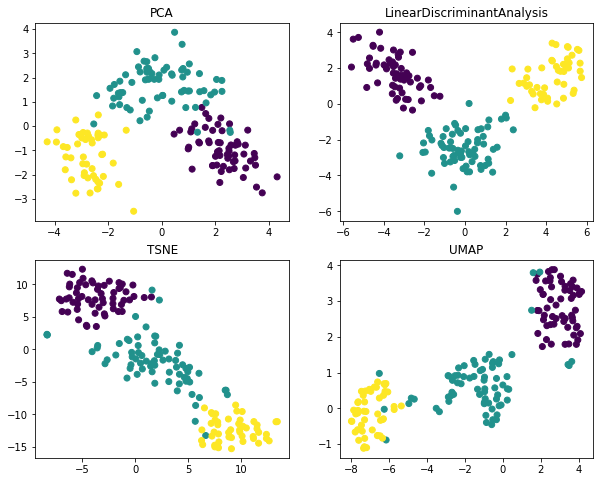

In [6]:
# Plot WITH standardization
fig, ax = plt.subplots(2,2, figsize=(10,8))
plot_reducer(PCA, X_wine, y_wine, ax[0][0])
plot_reducer(LDA, X_wine, y_wine, ax[0][1])
plot_reducer(TSNE, X_wine, y_wine, ax[1][0])
plot_reducer(UMAP, X_wine, y_wine, ax[1][1])

**Answer:** PCA seems significantly worse than LDA. This is not surprising, given that LDA is supervised, meaning that it has more (relevant) information to seperate the classes. This is particularly noticeable in the Wine dataset, where the separation is basically perfect. The two other algorithms seem better than PCA. In the Wine dataset, both TSNE and UMAP also appears better than LDA, but not in the Digits dataset. Perhaps this is because there are fewer classes in the Wine dataset, such that a supervised algorithm (LDA in this case) has a fairly easy task at hand, thus fairly easily outperforming even more sophisticated non-linear algorithms.

## Problems from exercise set 4

In this problem we will try to implement and understand some of the ideas used in [Athey, Imbens (2015)](https://www.pnas.org/content/pnas/113/27/7353.full.pdf) to develop _Honest Inference_ in desicion tree models. The paper begins by covering honesty in a setting of population averages, and for estimating conditional means; so you will need to look towards the second half of the paper to get an impression of it's use for treatment-effect estimation.

> **Ex. 4.2.1:** What does it mean that a tree is _honest?_ In particular what are the implications in terms of 
> * The intuition for why honesty is required in order to get good local treatment effect estimates?
> * The practical implementation of the DT algorithm?

**Answer:** Honesty means that we split the data into two sets (analogous to a train/test split):
1. One which we build the tree based on
2. One we pass through the tree to get treatment effects

The intuition for this is that if we don't do it, the tree would group spuriously similar observations. This is analogous to overfitting.

Practically, the DT is implemented as follows:
1. *First half of data:* Train the decision tree. This is done by splitting leaves repeatedly based minizming the adjusted MSE (which adds the term $Y_i^2$ to the MSE, such as to avoid small leafs). 
2. *Other half of the data:* We estimate the heterogenous treatment effects, $\hat{\tau}(x)$, using the tree fitted in step 1 by comparing the treated and untreated in each leaf.